[View in Colaboratory](https://colab.research.google.com/github/BuzzWoll/Residential-Energy-Forecasting/blob/master/Submission_Version_Forecasting_electricity_demand.ipynb)

In [0]:
########################################################################################################
# The following code reproduces the work of:
# 
# Marino, D. L., Amarasinghe, K., & Manic, M. (2016, October). 
# Building energy load forecasting using deep neural networks. 
# In Industrial Electronics Society, IECON 2016-42nd Annual Conference of the IEEE (pp. 7046-7051). IEEE.
#
########################################################################################################

In [2]:
########################################################################################################
# Libraries
# Libraries are required such that we can concentrate on implementing the proposed architecture
########################################################################################################

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time
import random
from IPython.display import clear_output

from six.moves import range

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed, Dense, concatenate, Dropout, CuDNNLSTM, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import Sequence

from sklearn import svm
from sklearn import linear_model

Using TensorFlow backend.


In [0]:
########################################################################################################
# Data
########################################################################################################

# Downloading and loading the single residential power consumption dataset from UCI machine learning library
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen

resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip")
zipfile = ZipFile(StringIO(resp.read()))
df = pd.read_csv(zipfile.open('household_power_consumption.txt'),sep = ';',dtype={'Global_active_power':np.float64, 'Global_reactive_power':np.float64,
       'Voltage':np.float64, 'Global_intensity':np.float64, 'Sub_metering_1':np.float64, 'Sub_metering_2':np.float64,
       'Sub_metering_3':np.float64} ,na_values='?')

df['dateTime'] = pd.to_datetime(df['Date'] +' '+df['Time'], format = '%d/%m/%Y %H:%M:%S')
df.index = df['dateTime']

In [0]:
# Normalize data
def normalize(x):
  return (x-min(x))/(max(x)-min(x))

# Quickly pre-process and aggregate the data to a specific time level (e.g. hourly, minutely etc.)
def createFastAggregation(data,aggregation,normal=False):
  if(aggregation != '1T'):
    data = data.resample(aggregation).mean()
    data.reset_index(inplace=True)
  if(normal):
    data.Global_active_power = normalize(data.Global_active_power)
  data["day"] = data.dateTime.dt.day
  data["dayOfWeek"] = data.dateTime.dt.dayofweek
  data["hour"] = data.dateTime.dt.hour
  data["minute"] = data.dateTime.dt.minute
  data.index = data['dateTime']
  data = data.interpolate('index')
  return data

# Plot both curves for target and prediction values
def plot_results(predicted_data, true_data):
  fig = plt.figure(facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data, label='True Data')
  plt.plot(predicted_data, label='Prediction')
  plt.legend()
  plt.show()
  
# Plot results on training data and test data at once
def plot_train_test(pred_train, true_train,pred_test,true_test):
  fig = plt.figure(facecolor='white',figsize=(24,10))
  ax = fig.add_subplot(111)
  true_data = np.concatenate((true_train,true_test))
  predicted_data = np.concatenate((pred_train,pred_test))
  plt.axvline(x=pred_train.shape[0],color="red")
  ax.plot(true_data, label='True Data')
  plt.plot(predicted_data, label='Prediction')
  plt.legend()
  plt.show()

# Plot the RMSE error curve
def plot_error(error_seq,vals = []):
  fig = plt.figure(facecolor='white')
  plt.plot(np.concatenate(([None],error_seq)),label='RMSE')
  plt.legend()
  plt.show()

In [0]:
########################################################################################################
# All functions needed for the simple LSTM forecast:
########################################################################################################

# Create datasets for the simple LSTM
def generateBasicSets(data,lag,split):
  # lag = how long should the distance between input and output be
  # To get the paper results, set this to 1 and 5
  data = data.as_matrix()
  sequence_length = lag+1
  
  result = np.asarray([data[index: index + sequence_length,] for index in range(data.shape[0] - sequence_length)])
  row = round(split * result.shape[0])
  
  # np.random.shuffle(train) # shuffling didn't really change anything
  # this is a weird way of getting lagged data, this would also work if want sequences as input, just replace :1 with :-1
  x_train = result[:int(row), :1] 
  y_train = result[:int(row), -1,0] 
  x_test = result[int(row):, :1] 
  y_test = result[int(row):, -1,0] 
  return x_train,x_test,y_train,y_test

# Define the simple LSTM
def build_model(layers):
    model = Sequential()

    model.add(LSTM(layers[1],input_shape=(None,layers[0]),return_sequences=True)) 
    model.add(Dropout(0.1))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(layers[3],activation = "linear"))

    model.compile(loss="mse", optimizer='adam') # As defined in paper
    
    return model

# Simple LSTM training
def simpleLSTM(data,lag,train_test_split,epochs,batch_size,neuronsL1,neuronsL2):
  x_train,x_test,y_train,y_test = generateBasicSets(data,lag,train_test_split)
  model = build_model([x_train.shape[2], neuronsL1, neuronsL2, 1])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  
  return x_train,x_test,y_train,y_test, model
  
#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

# Multi step forecast using the prediction as new input
def multistepForecast(data,model,forecast_length,batch_size):
  forecasts = list()
  X = data[np.newaxis,0,]
  for i in range(0,forecast_length):
    forecast = model.predict(X,batch_size=batch_size)
    forecasts.append(forecast)
    X = np.concatenate((forecasts[-1][0],data[i,0,1:])).reshape((1,1,data.shape[2]))
  return np.asarray(forecasts)

# Create multiple LSTM models and use the last forecast value to create an error metric for the specific timestamp
def deliverForecastValues(data,sequence_length,lags,skip=1):# lags e.g. =[1,2,6,12,24,96,168]
  errors = list()
  for i in lags:
    _,x_test,_,y_test, model = simpleLSTM(data,i,0.75,10,sequence_length,50,50)
    res = list()
    print 'Starting prediction'
    for j in range(0,y_test.shape[0]-sequence_length):
      if (j%skip) == 0:
        res.append((model.predict(x_test[j:j+sequence_length],batch_size=sequence_length)[-1]-y_test[j+sequence_length-1])**2)
    errors.append((i,np.sqrt(np.mean(res))))
    print 'finished model with lag: ',i,' result: ',(i,np.sqrt(np.mean(res)))
  return errors

In [0]:
########################################################################################################
# Generator Class for seq2seq LSTM
########################################################################################################

# taken from https://github.com/keras-team/keras-preprocessing/pull/7/commits/8514b364588c5d0961e90a9b7513d868ab8f80ff by Tanguy Urvoy, which is a current pull request for keras,
# i have modified it such that it takes lists as input and creates a generator for multiple inputs and outputs
# Most of the code is just a modified Keras implentation and the entire code is open source

# This is a definition for a generator which will automatically feed the sequence to sequence LSTM with batches
class multiAdvancedTimeseriesGenerator(Sequence):
    def __init__(self, data, targets, length=None,
                 sampling_rate=1,
                 stride=1,
                 start_index=0, end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=32,
                 hlength=None,
                 target_seq=False,
                 gap=None,
                 dtype=None):

        self.hlength = hlength
        if not isinstance(data,list):
          data = [data]
        if not isinstance(targets,list):
          targets = [targets]
        self.data = data
        self.targets = targets
        
        
        for i,_ in enumerate(data):
            self.data[i] = np.asarray(data[i])
        for j,_ in enumerate(targets):
            self.targets[j] = np.asarray(targets[j])
            if target_seq and len(self.targets[j].shape) < 2:
                self.targets[j] = np.expand_dims(self.targets[j], axis=-1) 
        
        
        if dtype is None:
            self.data_type = []
            self.targets_type = []
            for i in self.data:
              self.data_type.append(i.dtype)
            for j in self.targets:
              self.targets_type.append(j.dtype)
        else:
            self.data_type = dtype
            self.targets_type = dtype

        self.sampling_rate = sampling_rate
        self.batch_size = batch_size
        
        self.stride = stride
        if gap is None:
            gap = sampling_rate
        self.gap = gap

        sliding_win_size = (self.hlength - 1) * sampling_rate + gap
        self.start_index = start_index + sliding_win_size
        if end_index is None:
            end_index = data[0].shape[0]
        self.end_index = end_index
        self.reverse = reverse
        self.target_seq = target_seq
        self.len = (self.end_index -
                    self.start_index) // (self.batch_size * self.stride)


        self.perm = np.arange(self.start_index, self.end_index)
        if shuffle:
            np.random.shuffle(self.perm)
        
        
    def __len__(self):
        return self.len

    def _empty_batch(self, num_rows):
        sample_shapes = []
        for i in self.data:
          samples_shape = [num_rows,self.hlength] 
          samples_shape.extend(i.shape[1:])
          sample_shapes.append(samples_shape)
        target_shapes = []        
        for j in self.targets:
          if self.target_seq:
            targets_shape = [num_rows, self.hlength]
          else:
            targets_shape = [num_rows]
          targets_shape.extend(j.shape[1:])
          target_shapes.append(targets_shape)
        
        samples = [np.empty(sample_shapes[i],self.data_type[i]) for i,_ in enumerate(sample_shapes)]
        targets = [np.empty(target_shapes[i],self.targets_type[i]) for i,_ in enumerate(target_shapes)]
        
        return samples,targets

    def __getitem__(self, index):
        while index < 0:
            index += self.len
        assert index < self.len
        i = self.batch_size * self.stride * index
        assert i + self.batch_size * self.stride <= self.end_index
        rows = np.arange(i, i + self.batch_size * self.stride, self.stride)
        rows = self.perm[rows]

        samples,targets = self._empty_batch(len(rows))
        
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.gap - (self.hlength - 1) * self.sampling_rate,
                            rows[j] - self.gap + 1, self.sampling_rate)
            for i,_ in enumerate(samples):
              samples[i][j] = self.data[i][indices]
              if self.target_seq:
                  shifted_indices = range(rows[j] - (self.hlength - 1) * self.sampling_rate,
                                        rows[j] + 1, self.sampling_rate)
                  for i,_ in enumerate(targets):
                    targets[i][j] = self.targets[i][shifted_indices]

              else:
                for i,_ in enumerate(targets):
                  targets[i][j] = self.targets[i][rows[j]]
                
        if self.reverse:
          for i,_ in enumerate(samples):
            samples[i] = samples[i][:, ::-1, ...]
          return samples,targets
        
        return  samples,targets
      


In [0]:
########################################################################################################
# Additional Functions needed for the seq2seq LSTM 
########################################################################################################

# Generate input data for the sequence to sequence lstm
def generateSets(data,seq_len):
  y_0_in = data[:-(seq_len+1),0]
  f_1_in = data[1:-seq_len,1:]
  input_1 = np.concatenate((y_0_in,f_1_in),axis=1)
  y_1_out = data[1:,0]
  f_m_in = data[seq_len:,1:]
  y_m_out = data[seq_len:,0]
  return input_1,y_1_out,f_m_in,y_m_out

# Create a generator for the entire model
def generator_generator(data,sequence_length,start=0,end=None,batchSize=128):
  input_1,y_1_out,f_m_in,y_m_out = generateSets(data,sequence_length)
  return multiAdvancedTimeseriesGenerator([input_1,f_m_in],[y_1_out,y_m_out],hlength = sequence_length, sampling_rate=1, stride=1, start_index=start, end_index=end, shuffle=False, reverse=False, batch_size=batchSize,target_seq=True,gap=0)

# Create a generator only for the encoder part of the sequence to sequence LSTM
def enc_generator_generator(data,sequence_length,start=0,end=None,batchSize=128):
  input_1,y_1_out,f_m_in,y_m_out = generateSets(data,sequence_length)
  
  return multiAdvancedTimeseriesGenerator(input_1,y_1_out, hlength = sequence_length, sampling_rate=1, stride=1, start_index=start, end_index=end, shuffle=False, reverse=False, batch_size=batchSize,target_seq=True,gap=0)

# Function to get RMSE for every single timestep. 
# For the seq to seq model, we have both prediction and target sequences to calculate an error sequence.
def rmseCurve(model,generator,sequence_length):
  preds = model.predict_generator(generator)
  seqs = np.column_stack((preds[0][:,sequence_length-1,0],preds[1][:,:,0]))
  actuals = np.column_stack((generator[0][1][0][:,-1,0],generator[0][1][1][:,:,0]))
  
  for i in range(1,len(generator)):
    tmp = np.column_stack((generator[i][1][0][:,-1,0],generator[i][1][1][:,:,0]))
    actuals = np.concatenate((actuals,tmp))

  print 'Prediction and Actual Matrix sizes (reduced sizes depending on batch_size): ',seqs.shape,',', actuals.shape
  return np.sqrt(np.mean((seqs-actuals)**2,axis=0))


########################################################################################################
# Sequence to Sequence LSTM model definition
########################################################################################################

def createGeneratorEncDecModel(input_length,seq_len,no_params,units,dropout_rate = 0.1):
  
  # Encoder part:
  input_encoder = Input((seq_len,no_params+1),name='primary_input')
  encoder1,enc1_state_h,enc1_state_c = CuDNNLSTM(units = units[0],return_sequences=True,name='first_encoding_lstm',return_state=True)(input_encoder)
  drop_enc_1 = Dropout(rate=dropout_rate)(encoder1)
  encoder2,enc2_state_h,enc2_state_c = CuDNNLSTM(units = units[1],return_sequences=True,name='second_encoding_lstm',return_state=True)(drop_enc_1)
  drop_enc_2 = Dropout(rate=dropout_rate)(encoder2)
  
  encoder_out = TimeDistributed(Dense(1),name='enc_out_time_distributed')(drop_enc_2)
  
  # Decoder part:
  auxiliary_input = Input(shape=(seq_len,no_params),name='aux_input')

  decoder1 = CuDNNLSTM(units = units[2], return_sequences=True, name='first_decoding_lstm')(auxiliary_input,initial_state=[enc2_state_h,enc2_state_c])
  drop_dec_1 = Dropout(rate=dropout_rate)(decoder1)
  decoder2 = CuDNNLSTM(units = units[3], return_sequences=True, name='second_decoding_lstm')(drop_dec_1,initial_state=[enc2_state_h,enc2_state_c])
  drop_dec_2 = Dropout(rate=dropout_rate)(decoder2)
  decoder_out = TimeDistributed(Dense(1),name='dec_out_time_distributed')(drop_dec_2)
  enc_model = Model(inputs=input_encoder,outputs=encoder_out)
  model = Model(inputs=[input_encoder,auxiliary_input],outputs=[encoder_out,decoder_out])
  
  # Optimizer to use for training:
  customAdam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False,clipnorm=1.) # do not adjust decay for adam, as it should be learning decay by itself
  
  enc_model.compile(optimizer=customAdam,loss='mse')
  model.compile(optimizer=customAdam,loss='mse')
  
  return model,enc_model

# Define the training for the sequence to sequence model such that it can be reused
def seq2seqModel(data,sequence_length,batch_size,units=[20,20,20,20],enc_epochs=5,epochs=7):
  split = int(round(0.75 * data.shape[0]))
  train = np.asmatrix(data)[:split,:]
  test = np.asmatrix(data)[split:,:]
  
  #Create generators and model for training
  train_gen = generator_generator(train,sequence_length=sequence_length,batchSize=batch_size)
  test_gen = generator_generator(test,sequence_length=sequence_length,batchSize=batch_size)
  enc_gen_train = enc_generator_generator(train,sequence_length=sequence_length,batchSize=batch_size)
  enc_gen_test = enc_generator_generator(test,sequence_length=sequence_length,batchSize=batch_size)
  model, enc_model = createGeneratorEncDecModel(train.shape[0],sequence_length,no_params=data.shape[1]-1,units=units)
  
  # Train model
  enc_model.fit_generator(generator=enc_gen_train,epochs=enc_epochs,validation_data=enc_gen_test,validation_steps=(test.shape[0]/batch_size),steps_per_epoch=(train.shape[0]/batch_size))
  model.fit_generator(generator=train_gen,epochs=epochs,validation_data=test_gen,validation_steps=(test.shape[0]/batch_size),steps_per_epoch=(train.shape[0]/batch_size))
  return enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model

In [0]:
########################################################################################################
# Code for comparison models (SVM, linear model)
# Some code from the simple LSTM will be re-used here.
########################################################################################################

# Sample dataset such that a smaller subset can be used
# currently not needed because standard parameters are used for SVM
def sampleData(data,lag,split, samplefraction):
  x_train,x_test,y_train,y_test = generateBasicSets(data,lag,.75)
  x_train = x_train[:,0,:]
  x_test = x_test[:,0,:]
  train = np.array(pd.DataFrame(np.column_stack((x_train,y_train))).sample(frac=samplefraction,random_state=420))
  test = np.array(pd.DataFrame(np.column_stack((x_test,y_test))).sample(frac=samplefraction,random_state=420))
  x_train = train[:,0:x_train.shape[1]]
  y_train = train[:,-1]
  x_test = test[:,0:x_test.shape[1]]
  y_test = test[:,-1]
  return x_train,x_test,y_train,y_test

# Fit models to data, we only consider LM and SVR, so only those are possible
def fitModel(data,model_type,lag,frac=1):
  if model_type == 'LM':
      model = linear_model.LinearRegression()
  elif model_type == 'SVR':
      model = svm.SVR(kernel='rbf')    
  x_train,x_test,y_train,y_test = sampleData(data,lag,.75,frac)
  model.fit(x_train,y_train)
  return x_train,x_test,y_train,y_test, model

# Deprecated, do not use
# Originally intended to make this very comparable to LSTM but takes too much time
def forecastEvalWithSequences(data,sequence_length,lags):
  errors = list()
  for i in lags:
    _,x_test,_,y_test, model = fitModel(data,model_type,i,.5)
    print 'Starting prediction'
    res = list()
    for j in range(0,y_test.shape[0]-sequence_length):
      res.append((model.predict(x_test[j:j+sequence_length])[-1]-y_test[j+sequence_length-1])**2)
    errors.append((i,np.sqrt(np.mean(res))))
    print 'finished model with lag: ',i  
  return errors

# Evaluate different lagged models
def basicModelEval(data,sequence_length,lags,model_type='LM',frac=1):
  errors = list()
  for i in lags:
    _,x_test,_,y_test, model = fitModel(data,model_type,i,frac)
    print 'Starting prediction'
    res = (model.predict(x_test)-y_test)**2
    errors.append((i,np.sqrt(np.mean(res))))
    print 'finished ',model_type, '-model with lag: ',i  
  return errors

In [0]:
########################################################################################################
# The following code will basically be repeated 3 times for every time resolution.
# Starting here, is the actual execution of the code
########################################################################################################

In [0]:
########################################################################################################
# 1 Hour resolution
########################################################################################################

df_1h = createFastAggregation(df,'1H',normal = False)[['Global_active_power','day','dayOfWeek','hour']]
sequence_length = 168 # We will forecast data for 1 week with hourly resolution
measure_points = [1,12,24,96,168] # And consider different interesting measure points like after 1 day and 7days

In [0]:
# Basic LM RMSE for different points in the entire sequence
lmErrors = basicModelEval(df_1h,sequence_length,measure_points,model_type='LM')
clear_output()
print(lmErrors)

[(1, 0.5695033531223364), (12, 0.7783492778159115), (24, 0.699846388094205), (96, 0.7196394921950185), (168, 0.7098935060900745)]


In [0]:
# Basic SVR RMSE for different points in the entire sequence
svrErrors = basicModelEval(df_1h,sequence_length,measure_points,model_type='SVR',frac=0.5)
clear_output()
print(svrErrors)

[(1, 0.5603013937947293), (12, 0.726688527952068), (24, 0.7183327725078575), (96, 0.7256564488127123), (168, 0.74034480247782)]


In [0]:
# Basic LSTM RMSE for different points in the entire sequence
errors = deliverForecastValues(df_1h,sequence_length,measure_points)
clear_output()
print(errors)

[(1, 0.5510628), (12, 0.7027711), (24, 0.6896555), (96, 0.71281016), (168, 0.69862413)]


In [0]:
# Train a sample network for graphs
x_train,x_test,y_train,y_test, model = simpleLSTM(df_1h,5,.75,10,sequence_length,50,50)

Train on 20749 samples, validate on 5188 samples
Epoch 1/10
20749/20749 [==============================] - 4s 196us/step - loss: 1.0749 - val_loss: 0.5711
Epoch 2/10
20749/20749 [==============================] - 2s 91us/step - loss: 0.8446 - val_loss: 0.5415
Epoch 3/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.8241 - val_loss: 0.5451
Epoch 4/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.8135 - val_loss: 0.5299
Epoch 5/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.7833 - val_loss: 0.5105
Epoch 6/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.7575 - val_loss: 0.4649
Epoch 7/10
20749/20749 [==============================] - 2s 91us/step - loss: 0.7384 - val_loss: 0.4496
Epoch 8/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.7293 - val_loss: 0.4607
Epoch 9/10
20749/20749 [==============================] - 2s 91us/step - loss: 0.7175 - val_loss: 0.4561
Epoch

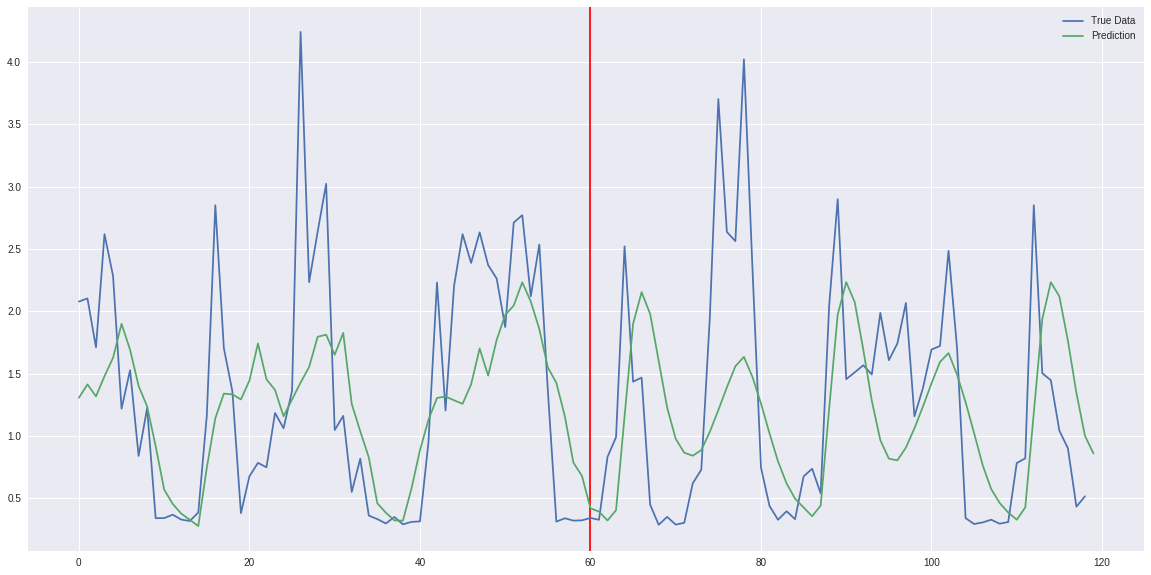

In [0]:
# Plot a specific section of the data and the corresponding predictions
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,sequence_length)
#plot_results(forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [12]:
# Create a sequence to sequence model
batch_size = 128
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_1h,sequence_length,batch_size,[50,50,50,50],6,10)

Epoch 1/6
202/202 [==============================] - 21s 102ms/step - loss: 0.7641 - val_loss: 0.4146
Epoch 2/6
202/202 [==============================] - 15s 75ms/step - loss: 0.4639 - val_loss: 0.3062
Epoch 3/6
202/202 [==============================] - 15s 74ms/step - loss: 0.4120 - val_loss: 0.2921
Epoch 4/6
202/202 [==============================] - 15s 73ms/step - loss: 0.3887 - val_loss: 0.3014
Epoch 5/6
202/202 [==============================] - 14s 70ms/step - loss: 0.3711 - val_loss: 0.3128
Epoch 6/6
202/202 [==============================] - 14s 70ms/step - loss: 0.3701 - val_loss: 0.2767
Epoch 1/10
202/202 [==============================] - 36s 179ms/step - loss: 1.1867 - enc_out_time_distributed_loss: 0.3894 - dec_out_time_distributed_loss: 0.7973 - val_loss: 0.8199 - val_enc_out_time_distributed_loss: 0.2801 - val_dec_out_time_distributed_loss: 0.5398
Epoch 2/10
202/202 [==============================] - 28s 136ms/step - loss: 1.0735 - enc_out_time_distributed_loss: 0.354

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [0]:
# Calculate the error curve
errorcurve = rmseCurve(model,test_gen,sequence_length)

Prediction and Actual Matrix sizes (reduced sizes depending on batch_size):  (8192, 169) , (8192, 169)


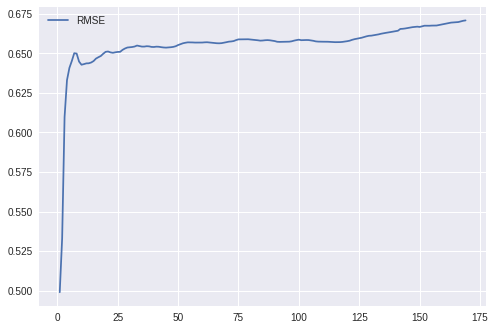

1 0.5331831961587308
12 0.6436154195523441
24 0.650791634261004
96 0.6574964941379952
168 0.6706987481147445


In [0]:
plot_error(errorcurve)
for i in measure_points:
    print i,errorcurve[i]

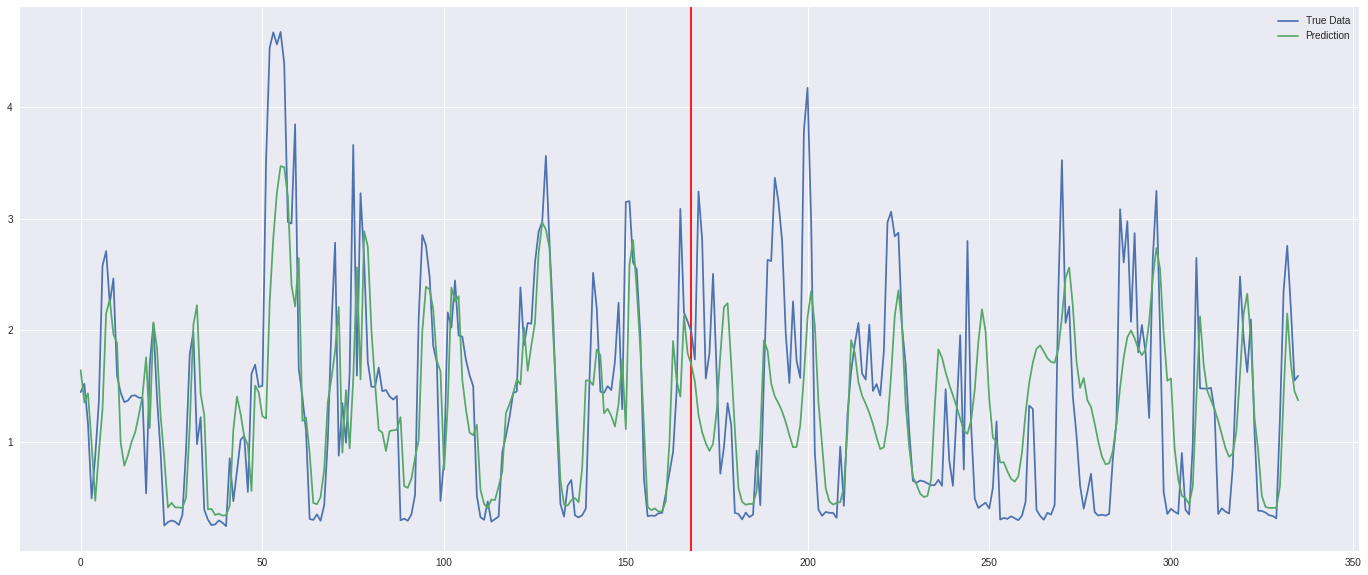

In [15]:
# plot encoder and decoder predictions on the input sequence (first part) and target sequence (second part)
start = 500
plot_train_test(preds_enc[start],test[start+1:sequence_length+start+1,0],preds[1][start],test[sequence_length+start+1:2*sequence_length+start+1,0])

In [0]:
########################################################################################################
# 15Min
########################################################################################################
df_15min = createFastAggregation(df,'15T')[['Global_active_power','day','dayOfWeek','hour','minute']]
sequence_length = 96
measure_points = [1,4,24,48,96]

In [0]:
# Basic LM RMSE for different points in the entire sequence
lmErrors = basicModelEval(df_15min,sequence_length,measure_points,model_type='LM')
clear_output()
print(lmErrors)

[(1, 0.4885429441870657), (4, 0.7431990412621312), (24, 0.8591889489763286), (48, 0.8690726578535088), (96, 0.8026180623136171)]


In [0]:
# Basic SVR RMSE for different points in the entire sequence
svrErrors = basicModelEval(df_15min,sequence_length,measure_points,model_type='SVR',frac=0.125)
clear_output()
print(svrErrors)

[(1, 0.5266076050774319), (4, 0.74022832151367), (24, 0.8392003694176255), (48, 0.8403381397926084), (96, 0.8078160635155446)]


In [0]:
errors = deliverForecastValues(df_15min,sequence_length,measure_points)
clear_output()
print(errors)

[(1, 0.48182917), (4, 0.7172324), (24, 0.78559846), (48, 0.79398173), (96, 0.78355557)]


In [0]:
x_train,x_test,y_train,y_test, model = simpleLSTM(df_15min,5,.75,10,sequence_length,50,50)

Train on 83008 samples, validate on 20752 samples
Epoch 1/10
83008/83008 [==============================] - 18s 214us/step - loss: 0.8416 - val_loss: 0.5344
Epoch 2/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7629 - val_loss: 0.5388
Epoch 3/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7544 - val_loss: 0.5111
Epoch 4/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7493 - val_loss: 0.5767
Epoch 5/10
83008/83008 [==============================] - 14s 163us/step - loss: 0.7433 - val_loss: 0.5082
Epoch 6/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7409 - val_loss: 0.5099
Epoch 7/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7339 - val_loss: 0.5261
Epoch 8/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7292 - val_loss: 0.4957
Epoch 9/10
83008/83008 [==============================] - 14s 164us/step - loss: 0.7228 - val_

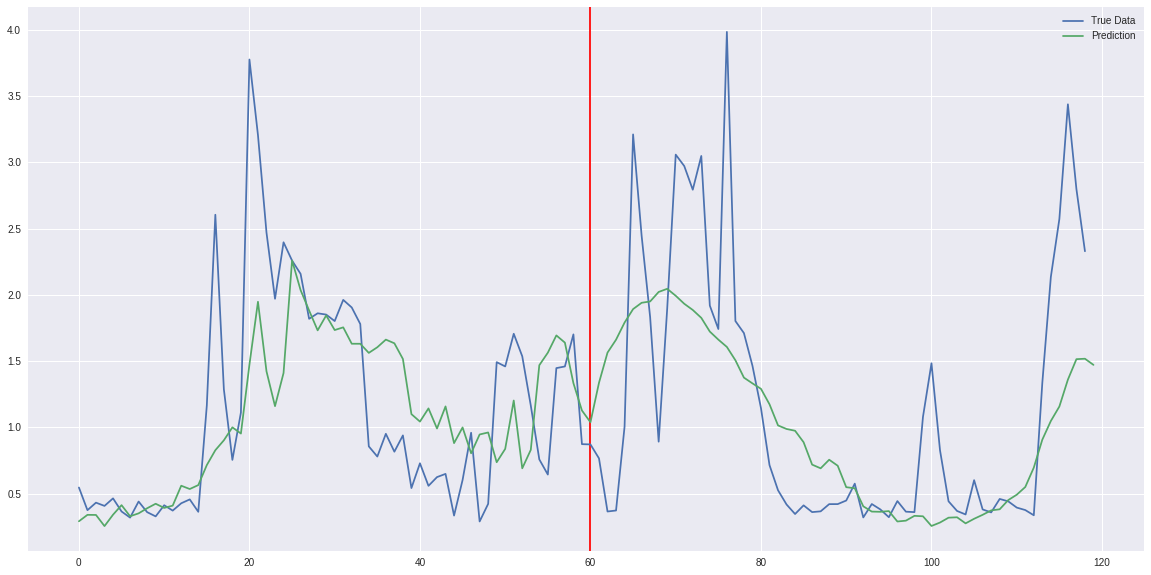

In [0]:
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,sequence_length)

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [0]:
batch_size = 128
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_15min,sequence_length,batch_size,[50,50,50,50],6,10)

Epoch 1/6
810/810 [==============================] - 49s 60ms/step - loss: 0.4870 - val_loss: 0.2602
Epoch 2/6
810/810 [==============================] - 47s 59ms/step - loss: 0.3097 - val_loss: 0.2371
Epoch 3/6
810/810 [==============================] - 46s 57ms/step - loss: 0.3009 - val_loss: 0.2296
Epoch 4/6
810/810 [==============================] - 45s 55ms/step - loss: 0.2959 - val_loss: 0.2468
Epoch 5/6
810/810 [==============================] - 45s 55ms/step - loss: 0.2903 - val_loss: 0.2227
Epoch 6/6
810/810 [==============================] - 43s 54ms/step - loss: 0.2850 - val_loss: 0.2269
Epoch 1/10
810/810 [==============================] - 98s 120ms/step - loss: 1.2043 - enc_out_time_distributed_loss: 0.2945 - dec_out_time_distributed_loss: 0.9098 - val_loss: 0.8362 - val_enc_out_time_distributed_loss: 0.2208 - val_dec_out_time_distributed_loss: 0.6154
Epoch 2/10
810/810 [==============================] - 93s 115ms/step - loss: 1.0870 - enc_out_time_distributed_loss: 0.2803

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [0]:
errorcurve_15min = rmseCurve(model,test_gen,sequence_length)

Prediction and Actual Matrix sizes (reduced sizes depending on batch_size):  (34304, 97) , (34304, 97)


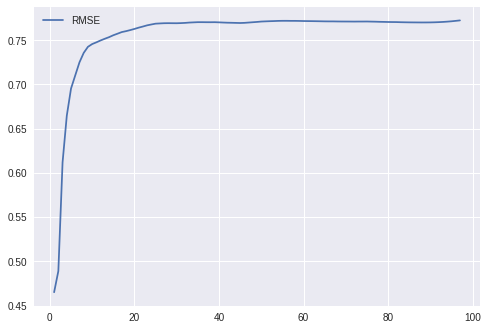

1 0.48903743006435324
4 0.6953074990765636
24 0.7686492040442955
48 0.7706096420716142
96 0.7723224643625718


In [0]:
plot_error(errorcurve_15min)
for i in measure_points:
    print i,errorcurve_15min[i]

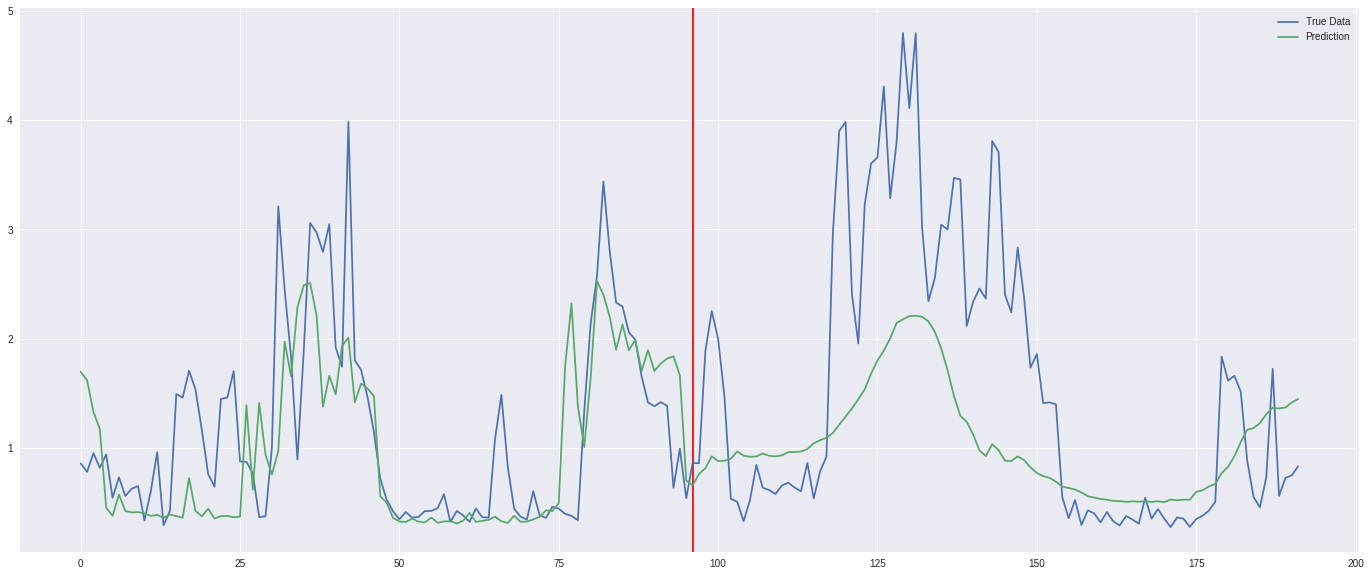

In [0]:
start = 180
plot_train_test(preds_enc[start],test[start+1:sequence_length+start+1,0],preds[1][start],test[sequence_length+start+1:2*sequence_length+start+1,0])

In [0]:
########################################################################################################
# 1Min
########################################################################################################
df_1min = createFastAggregation(df,'1T')[['Global_active_power','day','dayOfWeek','hour','minute']]
sequence_length = 120
measure_points = [1,5,30,60,120]

In [0]:
# Basic LM RMSE for different points in the entire sequence
lmErrors = basicModelEval(df_1min,sequence_length,measure_points,model_type='LM',frac=0.5)
clear_output()
print(lmErrors)

[(1, 0.22478547642692548), (5, 0.46382022822434726), (30, 0.7437796201460137), (60, 0.8292060391319453), (120, 0.8982428470666317)]


In [0]:
# Basic SVR RMSE for different points in the entire sequence
svrErrors = basicModelEval(df_1min,sequence_length,measure_points,model_type='SVR',frac=0.01)
clear_output()
print(svrErrors)

[(1, 0.5424324576105319), (5, 0.6334365195968361), (30, 0.8303971353286482), (60, 0.8587468125403672), (120, 0.8822243285438759)]


In [0]:
# Basic LSTM RMSE for different points in the entire sequence
errors1 = deliverForecastValues(df_1min,sequence_length,[measure_points[0]],skip=5)
clear_output()
print(errors1)

[(1, 0.22787575)]


In [0]:
errors2 = deliverForecastValues(df_1min,sequence_length,[measure_points[1]],skip=5)
clear_output()
print(errors2)

[(5, 0.46378353)]


In [0]:
errors3 = deliverForecastValues(df_1min,sequence_length,[measure_points[2]],skip=5)
clear_output()
print(errors3)

[(30, 0.7122419)]


In [0]:
errors4 = deliverForecastValues(df_1min,sequence_length,[measure_points[3]],skip=5)
clear_output()
print(errors4)

[(60, 0.78062564)]


In [0]:
errors5 = deliverForecastValues(df_1min,sequence_length,[measure_points[4]],skip=5)
clear_output()
print(errors5)

[(120, 0.82222867)]


In [0]:
x_train,x_test,y_train,y_test, model = simpleLSTM(df_1min,5,.75,10,sequence_length,50,50)

In [0]:
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,sequence_length)

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [0]:
batch_size = 512
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_1min,sequence_length,batch_size,[50,50,50,50],6,10)

Epoch 1/6
3039/3039 [==============================] - 243s 80ms/step - loss: 0.1590 - val_loss: 0.0579
Epoch 2/6
3039/3039 [==============================] - 241s 79ms/step - loss: 0.0870 - val_loss: 0.0501
Epoch 3/6
3039/3039 [==============================] - 240s 79ms/step - loss: 0.0814 - val_loss: 0.0491
Epoch 4/6
3039/3039 [==============================] - 238s 78ms/step - loss: 0.0761 - val_loss: 0.0462
Epoch 5/6
3039/3039 [==============================] - 243s 80ms/step - loss: 0.0729 - val_loss: 0.0459
Epoch 6/6
3039/3039 [==============================] - 241s 79ms/step - loss: 0.0713 - val_loss: 0.0454
Epoch 1/10
3039/3039 [==============================] - 468s 154ms/step - loss: 0.8639 - enc_out_time_distributed_loss: 0.0844 - dec_out_time_distributed_loss: 0.7795 - val_loss: 0.6169 - val_enc_out_time_distributed_loss: 0.0512 - val_dec_out_time_distributed_loss: 0.5657
Epoch 2/10
3039/3039 [==============================] - 464s 153ms/step - loss: 0.8136 - enc_out_time_

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [0]:
errorcurve_1min = rmseCurve(model,test_gen,sequence_length)

In [0]:
for i in measure_points:
    print i,errorcurve_1min[i]

1 0.2478529976703071
5 0.4452434546475183
30 0.6867749731837853
60 0.7557227595447201
120 0.814692185673133


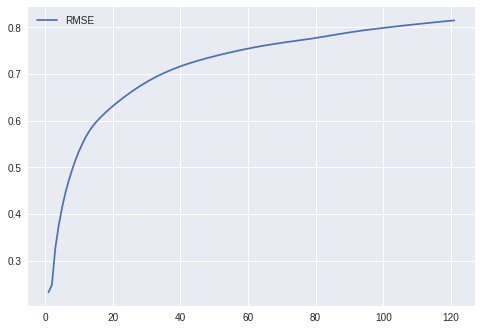

In [0]:
plot_error(errorcurve_1min)

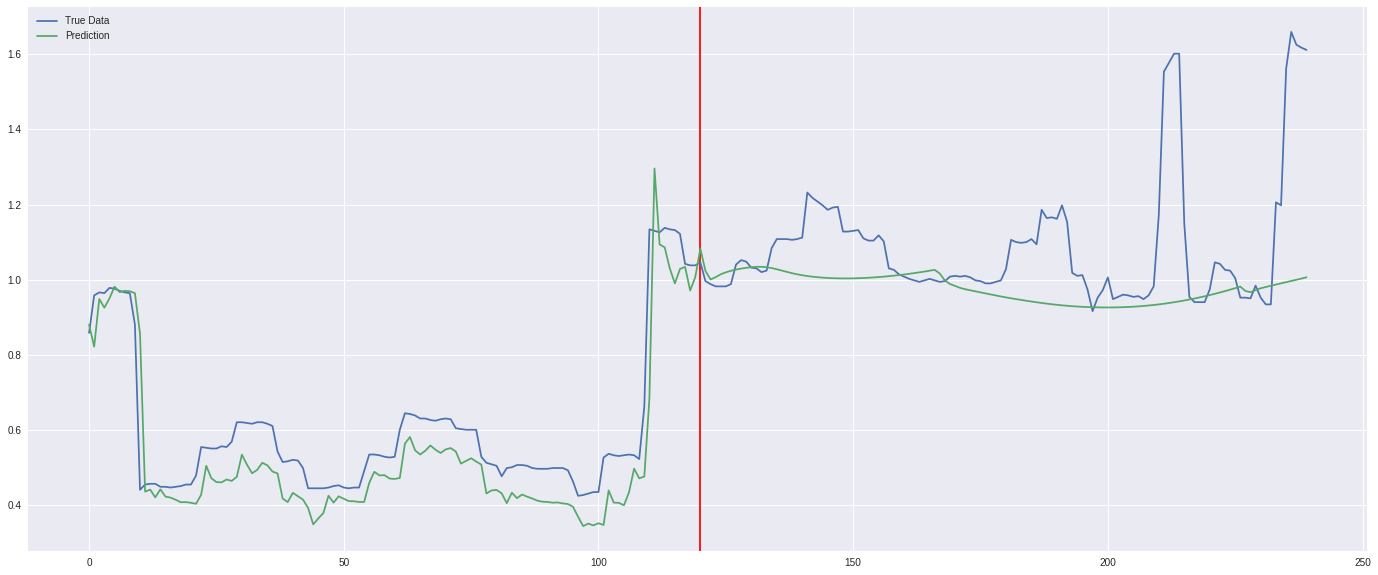

In [0]:

start = 5
plot_train_test(preds_enc[start],test[start+1:sequence_length+start+1,0],preds[1][start],test[sequence_length+start+1:2*sequence_length+start+1,0])
